In [ ]:
!pip install azure-cognitiveservices-vision-computervision
!pip install pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 10.7 MB/s eta 0:00:00


In [ ]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
import io
from PIL import Image
import sys
import time
import requests
import json

In [ ]:
def autentification():
  """
  Determina autentificarea
  :return: computervision_client - obiectul de autentificare
  """
  os.environ["VISION_API_KEY"] = "CrkPcmCb7BCJSH0m3shaWM7BcfTqSm0CRU94OmDIAE7KGl5uDbG3JQQJ99BCACi5YpzXJ3w3AAAFACOGlqGP"
  os.environ["VISION_API_ENDPOINT"] = "https://laboratory.cognitiveservices.azure.com/"

  subscription_key = os.environ.get("VISION_API_KEY")
  endpoint = os.environ.get("VISION_API_ENDPOINT")

  computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
  return computervision_client

computervision_client = autentification()

# Get text from image with ocr
Functia determina si returneaza textul detectat intr-o imagine


In [ ]:
def get_read_result_from_image(image_url):
    """
    Descarcă o imagine de la un URL și obține rezultatul de la Azure Computer Vision.
    :param image_url: URL-ul imaginii
    :return: Rezultatul returnat de computervision_client.get_read_result
    """
    response = requests.get(image_url)
    if response.status_code == 200:
        img = io.BytesIO(response.content)
    else:
        raise Exception("Eroare la descărcarea imaginii!")

    read_response = computervision_client.read_in_stream(
        image=img,
        mode="Printed",
        raw=True
    )

    operation_id = read_response.headers['Operation-Location'].split('/')[-1]
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    return read_result

In [ ]:
def get_text_from_image(image_url):
    """
    Determina si returneaza textul detectat intr-o imagine
    :param image_url: url-ul imaginii
    :return: textul detectat
    """
    response = requests.get(image_url)
    if response.status_code == 200:
        img = io.BytesIO(response.content)
    else:
        raise Exception("Eroare la descărcarea imaginii!")

    read_response = computervision_client.read_in_stream(
        image=img,
        mode="Printed",
        raw=True
    )

    operation_id = read_response.headers['Operation-Location'].split('/')[-1]
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    result = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                result.append(line.text)
    return result

# Distanta Levenshtein

Vom determina calitatea procesului de recunoastere a textului cu ajutorul distantei Levenshtein

Aceasta distanta determina numarul de operatii care trebuie efectuate asupra unui text pentru a ajunge la textul dorit, numarul de modificari

In [ ]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.3 MB/s eta 0:00:00


In [ ]:
from Levenshtein import distance as levenshtein_distance

def evaluate_text_recognition(recognized_text, groundTruth):
  """
  Determina calitatea procesului de recunoastere a textului
  :param recognized_text: textul recunoscut
  :param groundTruth: textul corect
  :return: char_acc, distance, word_acc, correct_words, total_words -
  calitatea procesului de recunoastere a textului
  """
  recognized_text = ' '.join(recognized_text).strip()
  reference_text = ' '.join(groundTruth).strip()


  distance = levenshtein_distance(recognized_text, reference_text)
  total_chars = len(reference_text)
  if total_chars > 0:
    char_acc = ((total_chars - distance) / total_chars) * 100
  else:
    char_acc = 0

  recognized_words = recognized_text.split()
  reference_words = reference_text.split()

  correct_words = sum(i == j for i, j in zip(recognized_words, reference_words))
  total_words = len(reference_words)
  if total_words > 0:
    word_acc = ((total_words - abs(total_words - correct_words)) / total_words) * 100
  else:
    word_acc = 0

  return char_acc, distance, word_acc, correct_words, total_words

In [ ]:
image_url1 = "https://raw.githubusercontent.com/lauradiosan/AI-UBB/main/2024-2025/labs/lab03/test1.png"
image1 = get_text_from_image(image_url1)
groundTruth1 = ["Google Cloud", "Platform"]

In [ ]:
image_url2 = "https://raw.githubusercontent.com/lauradiosan/AI-UBB/main/2024-2025/labs/lab03/test2.jpeg"
image2 = get_text_from_image(image_url2)
groundTruth2 = ["Succes in rezolvarea", "tEMELOR la", "LABORAtoaree de", "Inteligenta Artificiala!"]

In [ ]:
char_acc, distance, word_acc, correct_words, total_words = evaluate_text_recognition(image1, groundTruth1)
print("Primul text")
print(f"Char accuracy: {char_acc:.2f}% distanta Levenshtein: {distance}")
print(f"Word accuracy: {word_acc:.2f}%, correct words: {correct_words}, total words: {total_words}")

print("\nAl doilea text")
char_acc, distance, word_acc, correct_words, total_words = evaluate_text_recognition(image2, groundTruth2)
print(f"Char accuracy: {char_acc:.2f}% distanta Levenshtein: {distance}")
print(f"Word accuracy: {word_acc:.2f}%, correct words: {correct_words}, total words: {total_words}")


Primul text
Char accuracy: 100.00% distanta Levenshtein: 0
Word accuracy: 100.00%, correct words: 3, total words: 3

Al doilea text
Char accuracy: 91.67% distanta Levenshtein: 6
Word accuracy: 22.22%, correct words: 2, total words: 9


# Distanta Hamming

In [ ]:
from Levenshtein import hamming as hamming_distance

def hamming_distance_evaluation(recognized_text, groundTruth):
  """
  """
  recognized_text = ' '.join(recognized_text).strip()
  reference_text = ' '.join(groundTruth).strip()

  if len(recognized_text) != len(reference_text):
    raise ValueError("Sirurile trebuie sa aiba aceeasi lungime!")

  distance = hamming_distance(recognized_text, reference_text)

  total_chars = len(reference_text)
  if total_chars > 0:
    char_acc = ((total_chars - distance) / total_chars) * 100
  else:
    char_acc = 0

  recognized_words = recognized_text.split()
  reference_words = reference_text.split()
  correct_words = sum(i == j for i, j in zip(recognized_words, reference_words))
  total_words = len(reference_words)
  if total_words > 0:
    word_acc = ((total_words - abs(total_words - correct_words)) / total_words) * 100
  else:
    word_acc = 0

  return char_acc, distance, word_acc, correct_words, total_words

In [ ]:
char_acc, distance, word_acc, correct_words, total_words = hamming_distance_evaluation(image1, groundTruth1)
print("Primul text")
print(f"Char accuracy: {char_acc:.2f}% distanta Hamming: {distance}")
print(f"Word accuracy: {word_acc:.2f}%, correct words: {correct_words}, total words: {total_words}")

print("\nAl doilea text")
try:
  char_acc, distance, word_acc, correct_words, total_words = hamming_distance_evaluation(image2, groundTruth2)
  print(f"Char accuracy: {char_acc:.2f}% distanta Hamming: {distance}")
  print(f"Word accuracy: {word_acc:.2f}%, correct words: {correct_words}, total words: {total_words}")
except:
  print("Sirurile trebuie sa aiba aceeasi lungime!")


Primul text
Char accuracy: 100.00% distanta Hamming: 0
Word accuracy: 100.00%, correct words: 3, total words: 3

Al doilea text
Sirurile trebuie sa aiba aceeasi lungime!


# Distanta Jaccard

Verifica similaritatea caracterelor de pe aceasi pozitie din doua siruri

In [ ]:
def evaluate_with_jaccard(recognized_text, groundTruth):
  """
  """
  recognized_text = ' '.join(recognized_text).strip()
  reference_text = ' '.join(groundTruth).strip()

  recognized_words = recognized_text.split()
  reference_words = reference_text.split()

  set_recognised_words = set(recognized_words)
  set_reference_words = set(reference_words)

  intersection = set_recognised_words.intersection(set_reference_words)
  union_words = set_recognised_words.union(set_reference_words)

  if len(union_words) > 0:
    word_acc = (len(intersection) / len(union_words)) * 100
  else:
    word_acc = 0

  set_recognised_chars = set(recognized_text)
  set_reference_chars = set(reference_text)
  intersection_chars = set_recognised_chars.intersection(set_reference_chars)
  union_chars = set_recognised_chars.union(set_reference_chars)

  if len(union_chars) > 0:
    char_acc = (len(intersection_chars) / len(union_chars)) * 100
  else:
    char_acc = 0

  return char_acc, word_acc

In [ ]:
char_acc, word_acc = evaluate_with_jaccard(image1, groundTruth1)
print("Primul text")
print(f"  Similaritate cuvinte (Jaccard): {char_acc:.2f}")
print(f"  Similaritate caractere (Jaccard): {word_acc:.2f}")

char_acc, word_acc = evaluate_with_jaccard(image2, groundTruth2)
print("\nAl doilea text")
print(f"  Similaritate cuvinte (Jaccard): {char_acc:.2f}")
print(f"  Similaritate caractere (Jaccard): {word_acc:.2f}")

Primul text
  Similaritate cuvinte (Jaccard): 100.00
  Similaritate caractere (Jaccard): 100.00

Al doilea text
  Similaritate cuvinte (Jaccard): 86.21
  Similaritate caractere (Jaccard): 26.67


# Determina coordonate text

In [ ]:
image_url1 = "https://raw.githubusercontent.com/lauradiosan/AI-UBB/main/2024-2025/labs/lab03/test1.png"
image1 = get_read_result_from_image(image_url1)
groundTruth1 = ["Google Cloud", "Platform"]

In [ ]:
image_url2 = "https://raw.githubusercontent.com/lauradiosan/AI-UBB/main/2024-2025/labs/lab03/test2.jpeg"
image2 = get_read_result_from_image(image_url2)
groundTruth2 = ["Succes in rezolvarea", "tEMELOR la", "LABORAtoarele de", "Inteligenta Artificiala!"]

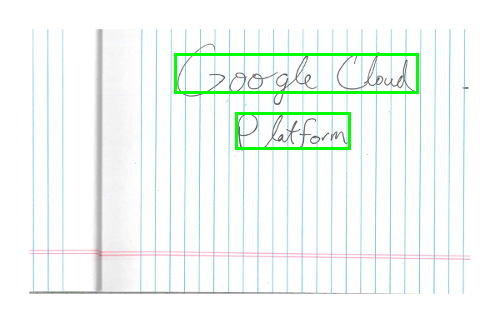

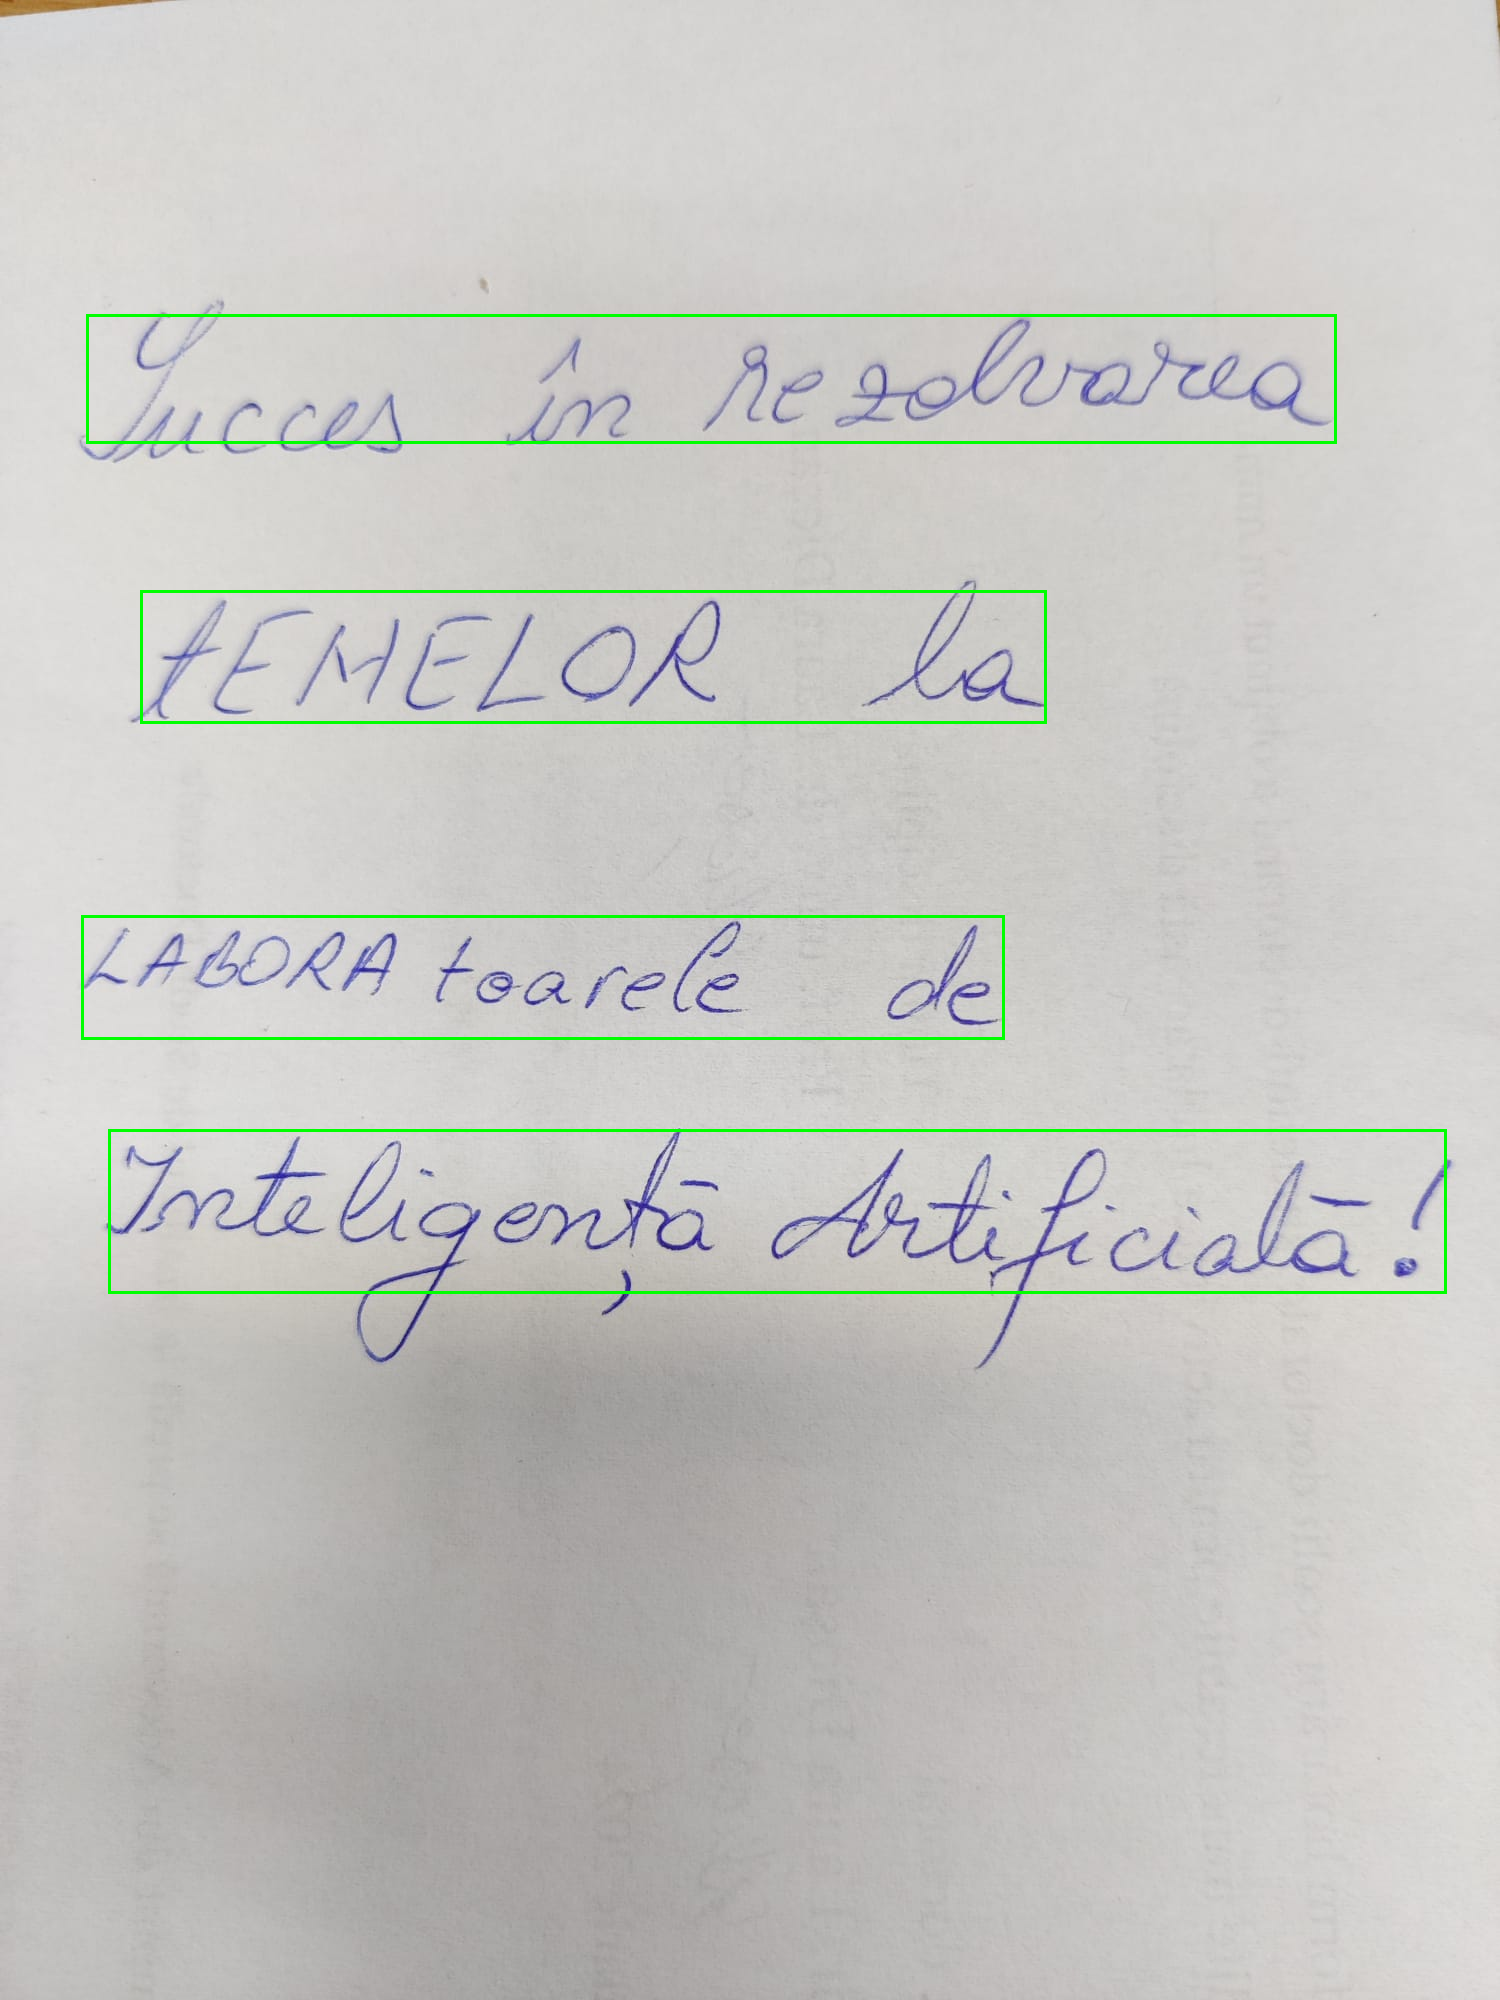

In [ ]:
import requests
from PIL import Image, ImageDraw
from io import BytesIO

def get_location_of_text_file(image_path):
    read_result = get_read_result_from_image(image_path)
    locations = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                x1, y1, x2, y2, x3, y3, x4, y4 = line.bounding_box
                locations.append([x1, y1, x3, y3])
    return locations

def image_with_box_surrounding_text(image_url):
    response = requests.get(image_url)
    if response.status_code != 200:
        raise Exception(f"Failed to download image from {image_url}")

    image = Image.open(BytesIO(response.content))
    draw = ImageDraw.Draw(image)

    locations = get_location_of_text_file(image_url)

    for location in locations:
        x1, y1, x3, y3 = location
        draw.rectangle([x1, y1, x3, y3], outline=(0, 255, 0), width=3)
    display(image)

groundTruthBoxes1 = []
groundTruthBoxes2 = []

groundTruthBox1 = get_location_of_text_file(image_url1)
groundTruthBox2 = get_location_of_text_file(image_url2)

image_with_box_surrounding_text(image_url1)
image_with_box_surrounding_text(image_url2)

for box1 in groundTruthBox1:
  groundTruthBoxes1.append(box1)
for box2 in groundTruthBox2:
  groundTruthBoxes2.append(box2)

In [ ]:
def extract_bounding_boxes(read_result):
    """
    Extrage doar bounding box-urile din rezultatul returnat de Azure Computer Vision.
    :param read_result: Rezultatul returnat de computervision_client.get_read_result
    :return: Lista de bounding box-uri (fiecare bounding box este o listă de coordonate)
    """
    bounding_boxes = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                bounding_box = line.bounding_box
                bounding_boxes.append(bounding_box)
    return bounding_boxes

def convert_to_simple_bbox(polygon_bbox):
    """
    Convertește un bounding box poligonal în formatul simplu [x1, y1, x2, y2].
    :param polygon_bbox: Lista de 8 valori [x1, y1, x2, y2, x3, y3, x4, y4]
    :return: Lista de 4 valori [x1, y1, x2, y2]
    """
    x_coords = polygon_bbox[::2]
    y_coords = polygon_bbox[1::2]

    x1 = min(x_coords)
    y1 = min(y_coords)
    x2 = max(x_coords)
    y2 = max(y_coords)

    return [x1, y1, x2, y2]


In [ ]:
read_result1 = get_read_result_from_image(image_url1)
bounding_box11 = extract_bounding_boxes(read_result1)
bounding_boxes1 = []
bounding_boxes2 = []
for box1 in bounding_box11:
  bounding_bbox1 = convert_to_simple_bbox(box1)
  bounding_boxes1.append(bounding_bbox1)

read_result2 = get_read_result_from_image(image_url2)
bounding_box22 = extract_bounding_boxes(read_result2)
for box2 in bounding_box22:
    bounding_bbox2 = convert_to_simple_bbox(box2)
    bounding_boxes2.append(bounding_bbox2)

In [ ]:
#Calculam IoU (Intersection over unoin) - masoara suprapunerea dintre doua bounding box-uri
def calculate_iou(box1, box2):
    """
    Calculează Intersection over Union (IoU) între două bounding box-uri.
    Formatul bounding box-urilor: [x1, y1, x2, y2]
    """
    if len(box1) != 4 or len(box2) != 4:
        raise ValueError("Bounding box-urile trebuie să aibă formatul [x1, y1, x2, y2]")

    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = area1 + area2 - intersection

    iou = intersection / union if union != 0 else 0
    return iou



In [ ]:
def evauate_localization(groundTruthBoxes, predicted_box, iou_threshold = 0.5):
  true_positive = 0
  false_positive = 0
  false_negative = 0

  for gt_box in groundTruthBoxes:
    found_match = False
    for pred_box in predicted_box:
      iou = calculate_iou(gt_box, pred_box)
      if iou >= iou_threshold:
        true_positive += 1
        found_match = True
        break
    if not found_match:
      false_negative += 1

  false_postive = len(predicted_box) - true_positive

  precision = true_positive / (true_positive + false_postive) if (true_positive + false_postive) > 0 else 0
  recall = true_positive / (true_positive + false_negative)
  f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

  return {
        "iou_threshold": iou_threshold,
        "true_positives": true_positive,
        "false_positives": false_positive,
        "false_negatives": false_negative,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

result1 = evauate_localization(groundTruthBoxes1, bounding_boxes1)
result2 = evauate_localization(groundTruthBoxes2, bounding_boxes2)
print(result1)
print(result2)


NameError: name 'groundTruthBoxes1' is not defined

# Posibilitati de imbunatatire


# Preprocesarea imaginii


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# -> Conversie în tonuri de gri
# -> Contrast Limited Adaptive Histogram Equalization (CLAHE): Îmbunătățește contrastul
# -> Filtrare bilaterală: Reduce zgomotul, menținând claritatea marginilor, ceea ce ajută la OCR.
# -> Threshold adaptiv: Binarizează imaginea, făcând textul mai vizibil pentru recunoaștere.

In [ ]:
def enhance_image(image_cv):
    gray = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    enhanced = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)
    enhanced = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)

    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    return enhanced
    return enhanced

def display_images(original, enhanced):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Imagine Originală")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB))
    plt.title("Imagine Îmbunătățită")
    plt.axis("off")

    plt.show()


In [ ]:
def get_text_from_image2(image_url):
    """
    Determină și returnează textul detectat într-o imagine.
    :param image_url: URL-ul imaginii
    :param computervision_client: Clientul pentru serviciul de Computer Vision
    :return: textul detectat
    """
    response = requests.get(image_url)
    if response.status_code == 200:
        img = Image.open(io.BytesIO(response.content))
        image_cv = np.array(img)
        image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

        enhanced_image = enhance_image(image_cv)

        display_images(image_cv, enhanced_image)

        enhanced_image_pil = Image.fromarray(cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2RGB))
        img_byte_arr = io.BytesIO()
        enhanced_image_pil.save(img_byte_arr, format='PNG')
        img_byte_arr.seek(0)
    else:
        raise Exception("Eroare la descărcarea imaginii!")

    read_response = computervision_client.read_in_stream(
        image=img_byte_arr,
        mode="Printed",
        raw=True
    )

    operation_id = read_response.headers['Operation-Location'].split('/')[-1]
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    result = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                result.append(line.text)
    return result

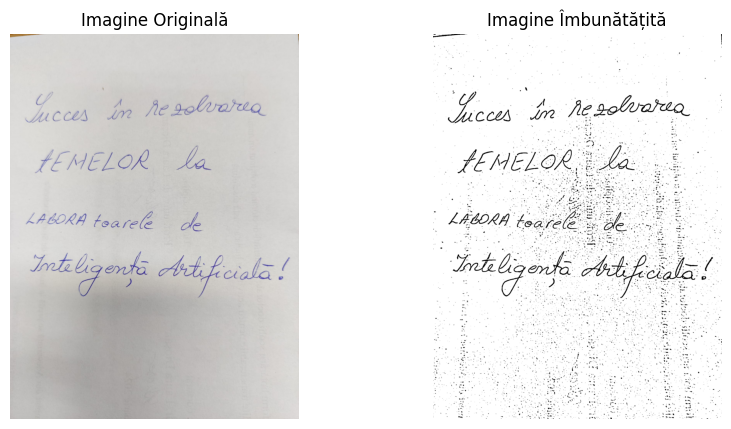

['Succes in resolvarea', 'tENELOR la', 'LABORA toarele', 'de', 'Inteligenta Artificiala!']


In [ ]:
image_2_noised = get_text_from_image2(image_url2)
print(image_2_noised)


In [ ]:
image_url2 = "https://raw.githubusercontent.com/lauradiosan/AI-UBB/main/2024-2025/labs/lab03/test2.jpeg"
image2_o = get_text_from_image(image_url2)
groundTruth2 = ["Succes in rezolvarea", "tEMELOR la", "LABORAtoarele de", "Inteligenta Artificiala!"]

In [ ]:
#pentru a putea vedea diferenta dintre poza originala si cea procesata vom folosi:
# functia de evaluate text recognition cu distanta Levenshtein

print("\nAl doilea text")
char_acc, distance, word_acc, correct_words, total_words = evaluate_text_recognition(image2_o, groundTruth2)
print(f"Char accuracy: {char_acc:.2f}% distanta Levenshtein: {distance}")
print(f"Word accuracy: {word_acc:.2f}%, correct words: {correct_words}, total words: {total_words}")

print("\nAl doilea text")
char_acc, distance, word_acc, correct_words, total_words = evaluate_text_recognition(image_2_noised, groundTruth2)
print(f"Char accuracy: {char_acc:.2f}% distanta Levenshtein: {distance}")
print(f"Word accuracy: {word_acc:.2f}%, correct words: {correct_words}, total words: {total_words}")



Al doilea text
Char accuracy: 93.15% distanta Levenshtein: 5
Word accuracy: 22.22%, correct words: 2, total words: 9

Al doilea text
Char accuracy: 95.89% distanta Levenshtein: 3
Word accuracy: 33.33%, correct words: 3, total words: 9
